## Lending Dataset – Linear Regression

In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Step A: Read in Dataset and Display DataFrame Attributes

In [36]:
cols = ['ID', 'LoanAmt', 'IntRate', 'LoanTerm', 'Debt2Inc', 'Home',
        'MonthlyInc', 'FICO-Range', 'RevCredBal', 'EmpLen']
loan_data = pd.read_csv('loansData.csv', names = cols, index_col = 'ID')
loan_data.head()

,LoanAmt,IntRate,LoanTerm,Debt2Inc,Home,MonthlyInc,FICO-Range,RevCredBal,EmpLen
ID,,,,,,,,,
81174,20000,8.90%,36 months,14.90%,MORTGAGE,6541.67,735-739,14272.0,< 1 year
99592,19200,12.12%,36 months,28.36%,MORTGAGE,4583.33,715-719,11140.0,2 years
80059,35000,21.98%,60 months,23.81%,MORTGAGE,11500.00,690-694,21977.0,2 years
33182,12000,11.71%,36 months,18.78%,RENT,3195.00,695-699,14469.0,9 years
62403,6000,15.31%,36 months,20.05%,OWN,4891.67,670-674,10391.0,3 years


In [37]:
loan_data.dtypes

LoanAmt         int64
IntRate        object
LoanTerm       object
Debt2Inc       object
Home           object
MonthlyInc    float64
FICO-Range     object
RevCredBal    float64
EmpLen         object
dtype: object

In [38]:
loan_data.shape

(1752, 9)

In [39]:
loan_data['LoanTerm'].value_counts()

36 months    1430
60 months     322
Name: LoanTerm, dtype: int64

In [40]:
loan_data['Home'].value_counts()

RENT        844
MORTGAGE    761
OWN         147
Name: Home, dtype: int64

In [41]:
loan_data['EmpLen'].value_counts()

10+ years    453
2 years      175
3 years      166
< 1 year     165
5 years      151
4 years      147
1 year       130
6 years      126
7 years      100
8 years       86
9 years       53
Name: EmpLen, dtype: int64

In [42]:
loan_data.describe()

,LoanAmt,MonthlyInc,RevCredBal
count,1752.000000,1752.000000,1752.000000
mean,11609.474886,5520.837854,13932.856164
std,7443.034671,3186.290186,13708.658521
min,1000.000000,1000.000000,0.000000
25%,6000.000000,3416.670000,5539.250000
50%,10000.000000,4833.330000,10738.500000
75%,15000.000000,6666.670000,17680.000000
max,35000.000000,39583.330000,143151.000000


In [43]:
loan_data[loan_data.RevCredBal == loan_data.RevCredBal.max()]

,LoanAmt,IntRate,LoanTerm,Debt2Inc,Home,MonthlyInc,FICO-Range,RevCredBal,EmpLen
ID,,,,,,,,,
17864,12000,8.88%,60 months,19.38%,MORTGAGE,4000.0,795-799,143151.0,4 years


Pick two interesting things from the descriptive statistics output and display the records in the dataset that correspond to the statistics.

In [44]:
loan_data[loan_data.MonthlyInc == loan_data.MonthlyInc.min()]

,LoanAmt,IntRate,LoanTerm,Debt2Inc,Home,MonthlyInc,FICO-Range,RevCredBal,EmpLen
ID,,,,,,,,,
53808,6000,13.11%,36 months,12.40%,RENT,1000.0,685-689,3622.0,1 year
67265,2100,14.33%,36 months,3.50%,OWN,1000.0,690-694,893.0,< 1 year


In [45]:
loan_data[loan_data.MonthlyInc == loan_data.MonthlyInc.max()]

,LoanAmt,IntRate,LoanTerm,Debt2Inc,Home,MonthlyInc,FICO-Range,RevCredBal,EmpLen
ID,,,,,,,,,
41411,35000,16.29%,36 months,17.17%,MORTGAGE,39583.33,705-709,55965.0,10+ years


### Step B: Clean the Data

1- Remove % sign from IntRate

In [46]:
ir = loan_data['IntRate'].values
ir[:5]

array(['8.90%', '12.12%', '21.98%', '11.71%', '15.31%'], dtype=object)

In [47]:
nopct = [x[:-1] for x in ir]
nopct[:5]

['8.90', '12.12', '21.98', '11.71', '15.31']

In [48]:
irFloat = [float(x) for x in nopct]
irFloat[:5]

[8.9, 12.12, 21.98, 11.71, 15.31]

In [49]:
loan_data['IntRate'] = irFloat
loan_data['IntRate'].dtype

dtype('float64')

2- Remove % sign from Debt2Inc

In [50]:
di = loan_data['Debt2Inc'].values
di[:5]

array(['14.90%', '28.36%', '23.81%', '18.78%', '20.05%'], dtype=object)

In [51]:
nopct = [x[:-1] for x in di]
nopct[:5]

['14.90', '28.36', '23.81', '18.78', '20.05']

In [52]:
diFloat = [float(x) for x in nopct]
diFloat[:5]

[14.9, 28.36, 23.81, 18.78, 20.05]

In [53]:
loan_data['Debt2Inc'] = diFloat
loan_data['Debt2Inc'].dtype

dtype('float64')

3- Split FICO-Range scores, find the mean, and replace the column with the mean

In [54]:
FICO_str = loan_data['FICO-Range'].values
FICO_str[:5]

array(['735-739', '715-719', '690-694', '695-699', '670-674'],
      dtype=object)

In [55]:
scores = [f_str.split('-') for f_str in FICO_str]
scores[:5]

[['735', '739'],
 ['715', '719'],
 ['690', '694'],
 ['695', '699'],
 ['670', '674']]

In [56]:
int_scores = [[int(sc) for sc in inner] for inner in scores]
int_scores[:5]

[[735, 739], [715, 719], [690, 694], [695, 699], [670, 674]]

In [57]:
meanFICO = [int((sc[0] + sc[1]) / 2) for sc in int_scores]
meanFICO[:5]

[737, 717, 692, 697, 672]

In [58]:
loan_data['FICO'] = meanFICO
loan_data = loan_data.drop('FICO-Range', axis=1)
loan_data.columns

Index(['LoanAmt', 'IntRate', 'LoanTerm', 'Debt2Inc', 'Home', 'MonthlyInc',
       'RevCredBal', 'EmpLen', 'FICO'],
      dtype='object')

4- Remove the ‘months’ word from LoanTerm

In [59]:
loan_str = loan_data['LoanTerm'].values
loan_str[:5]

array(['36 months', '36 months', '60 months', '36 months', '36 months'],
      dtype=object)

In [60]:
loans = [l_str.split(' ') for l_str in loan_str]
loans[:5]

[['36', 'months'],
 ['36', 'months'],
 ['60', 'months'],
 ['36', 'months'],
 ['36', 'months']]

In [61]:
months = [int(inner[0]) for inner in loans]
months[:5]

[36, 36, 60, 36, 36]

In [62]:
months = [0 if m == 36 else 1 for m in months]
months[:5]

[0, 0, 1, 0, 0]

In [63]:
loan_data['LoanTerm'] = months
loan_data['LoanTerm'].head()

ID
81174    0
99592    0
80059    1
33182    0
62403    0
Name: LoanTerm, dtype: int64

5- Change MORTGAGE to MORT in Home

In [64]:
loan_data.loc[loan_data.Home == 'MORTGAGE','Home'] = 'MORT'
loan_data['Home'].head()

ID
81174    MORT
99592    MORT
80059    MORT
33182    RENT
62403     OWN
Name: Home, dtype: object

6- Fix EmpLen variable values to be numeric

In [65]:
years = loan_data['EmpLen'].values
years[:5]

array(['< 1 year', '2 years', '2 years', '9 years', '3 years'],
      dtype=object)

In [66]:
year_list = [y.split(' ') for y in years]
year_list[:5]

[['<', '1', 'year'],
 ['2', 'years'],
 ['2', 'years'],
 ['9', 'years'],
 ['3', 'years']]

In [67]:
num_str = [x[0] for x in year_list]
num_str[:5]

['<', '2', '2', '9', '3']

In [68]:
emp_len = []
for num in num_str:
    if num == '<':
        emp_len.append(0)
    elif num == '10+':
        emp_len.append(10)
    else:
        emp_len.append(int (num))
emp_len[:5]

[0, 2, 2, 9, 3]

In [69]:
loan_data['EmpLen'] = emp_len
loan_data['EmpLen'].head()

ID
81174    0
99592    2
80059    2
33182    9
62403    3
Name: EmpLen, dtype: int64

In [70]:
loan_data.head()

,LoanAmt,IntRate,LoanTerm,Debt2Inc,Home,MonthlyInc,RevCredBal,EmpLen,FICO
ID,,,,,,,,,
81174,20000,8.90,0,14.90,MORT,6541.67,14272.0,0,737
99592,19200,12.12,0,28.36,MORT,4583.33,11140.0,2,717
80059,35000,21.98,1,23.81,MORT,11500.00,21977.0,2,692
33182,12000,11.71,0,18.78,RENT,3195.00,14469.0,9,697
62403,6000,15.31,0,20.05,OWN,4891.67,10391.0,3,672


### Step C: Transform the Home Categorical Variable to Dummies 

In [71]:
home_dum = pd.get_dummies(loan_data['Home'], prefix='Home_')

In [72]:
loan_X1 = loan_data[['LoanAmt','LoanTerm', 'Debt2Inc']].join(home_dum)
loan_X2 = loan_data[['MonthlyInc','RevCredBal','FICO','EmpLen']]
loan_Y = loan_data[['IntRate']]

In [73]:
loan_data = pd.concat([loan_Y, loan_X1, loan_X2], axis=1)
loan_data.head()

,IntRate,LoanAmt,LoanTerm,Debt2Inc,Home__MORT,Home__OWN,Home__RENT,MonthlyInc,RevCredBal,FICO,EmpLen
ID,,,,,,,,,,,
81174,8.90,20000,0,14.90,1,0,0,6541.67,14272.0,737,0
99592,12.12,19200,0,28.36,1,0,0,4583.33,11140.0,717,2
80059,21.98,35000,1,23.81,1,0,0,11500.00,21977.0,692,2
33182,11.71,12000,0,18.78,0,0,1,3195.00,14469.0,697,9
62403,15.31,6000,0,20.05,0,1,0,4891.67,10391.0,672,3


### Step D: Examine the Relationship Between the Variables

In [74]:
loan_corr = loan_data.corr()
loan_corr

,IntRate,LoanAmt,LoanTerm,Debt2Inc,Home__MORT,Home__OWN,Home__RENT,MonthlyInc,RevCredBal,FICO,EmpLen
IntRate,1.000000,0.308321,0.414420,0.157653,-0.086886,-0.007368,0.090279,0.018718,0.078770,-0.733519,0.039927
LoanAmt,0.308321,1.000000,0.370207,0.083909,0.151616,-0.049427,-0.122979,0.439503,0.364792,0.060730,0.157921
LoanTerm,0.414420,0.370207,1.000000,0.015259,0.047973,-0.021353,-0.035742,0.081958,0.093702,-0.011196,0.060672
Debt2Inc,0.157653,0.083909,0.015259,1.000000,-0.003505,0.023173,-0.009381,-0.178562,0.219052,-0.210367,0.019866
Home__MORT,-0.086886,0.151616,0.047973,-0.003505,1.000000,-0.265202,-0.844858,0.250199,0.208887,0.131209,0.243583
Home__OWN,-0.007368,-0.049427,-0.021353,0.023173,-0.265202,1.000000,-0.291776,-0.092213,-0.052714,0.003564,-0.024375
Home__RENT,0.090279,-0.122979,-0.035742,-0.009381,-0.844858,-0.291776,1.000000,-0.197034,-0.177969,-0.132138,-0.228111
MonthlyInc,0.018718,0.439503,0.081958,-0.178562,0.250199,-0.092213,-0.197034,1.000000,0.432443,0.114587,0.096702
RevCredBal,0.078770,0.364792,0.093702,0.219052,0.208887,-0.052714,-0.177969,0.432443,1.000000,0.003040,0.139835
FICO,-0.733519,0.060730,-0.011196,-0.210367,0.131209,0.003564,-0.132138,0.114587,0.003040,1.000000,0.020892


In [75]:
grps = ['NegStrong','NegMedium','Weak','PosMedium','PosStrong']
cols = ['IntRate', 'LoanAmt', 'LoanTerm', 'Debt2Inc', 'Home__MORT',
        'Home__OWN','Home__RENT','MonthlyInc', 'RevCredBal', 'FICO', 'EmpLen']
for col in cols:
    loan_corr[col] = pd.cut (loan_corr[col], 
        (-1,-0.7,-0.3,0.3,0.7,1), labels = grps)
loan_corr

,IntRate,LoanAmt,LoanTerm,Debt2Inc,Home__MORT,Home__OWN,Home__RENT,MonthlyInc,RevCredBal,FICO,EmpLen
IntRate,PosStrong,PosMedium,PosMedium,Weak,Weak,Weak,Weak,Weak,Weak,NegStrong,Weak
LoanAmt,PosMedium,PosStrong,PosMedium,Weak,Weak,Weak,Weak,PosMedium,PosMedium,Weak,Weak
LoanTerm,PosMedium,PosMedium,PosStrong,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak
Debt2Inc,Weak,Weak,Weak,PosStrong,Weak,Weak,Weak,Weak,Weak,Weak,Weak
Home__MORT,Weak,Weak,Weak,Weak,PosStrong,Weak,NegStrong,Weak,Weak,Weak,Weak
Home__OWN,Weak,Weak,Weak,Weak,Weak,PosStrong,Weak,Weak,Weak,Weak,Weak
Home__RENT,Weak,Weak,Weak,Weak,NegStrong,Weak,PosStrong,Weak,Weak,Weak,Weak
MonthlyInc,Weak,PosMedium,Weak,Weak,Weak,Weak,Weak,PosStrong,PosMedium,Weak,Weak
RevCredBal,Weak,PosMedium,Weak,Weak,Weak,Weak,Weak,PosMedium,PosStrong,Weak,Weak
FICO,NegStrong,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,PosStrong,Weak


In [76]:
loan_data = loan_data.drop(['Debt2Inc','Home__MORT','Home__OWN','Home__RENT','EmpLen'], axis=1)
loan_data.head()

,IntRate,LoanAmt,LoanTerm,MonthlyInc,RevCredBal,FICO
ID,,,,,,
81174,8.90,20000,0,6541.67,14272.0,737
99592,12.12,19200,0,4583.33,11140.0,717
80059,21.98,35000,1,11500.00,21977.0,692
33182,11.71,12000,0,3195.00,14469.0,697
62403,15.31,6000,0,4891.67,10391.0,672


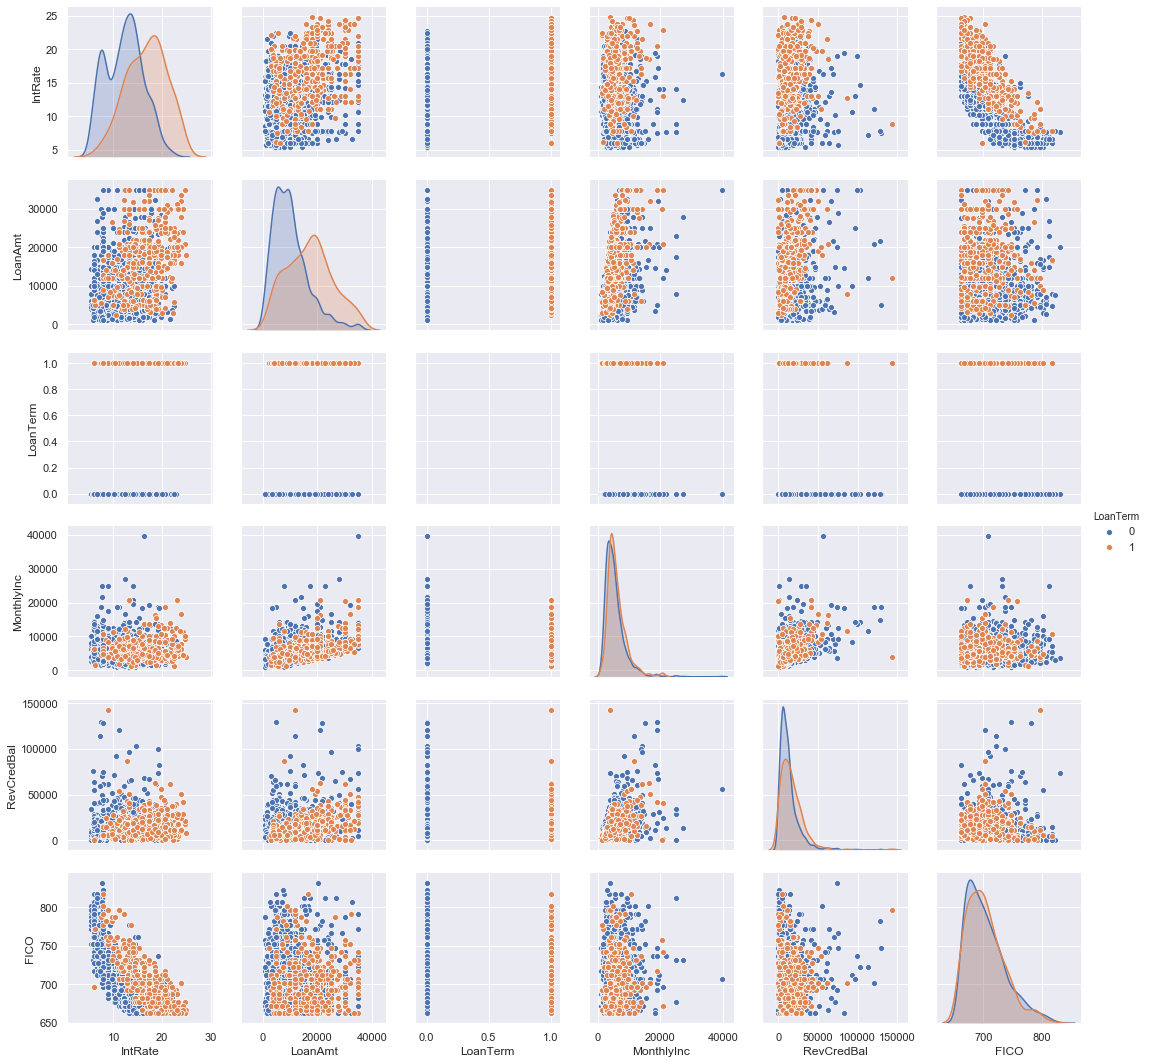

In [95]:
sns.pairplot (loan_data, hue = 'LoanTerm', height=2.5);

### Step E: Transforming the Variables Using Standardization

In [78]:
Y = loan_data ['IntRate']
X = loan_data.drop (['IntRate'], axis=1)
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

### Step F: Model Formation and Selection

#Full model: 
X_std0 : loan_data[['LoanAmt', 'LoanTerm', 'MonthlyInc', 'RevCredBal', 'FICO']].values

#Full model-MonthlyInc:
X_std1 : loan_data[['LoanAmt', 'LoanTerm', 'RevCredBal', 'FICO']].values

#Full model-RevCredBal:
X_std2 : loan_data[['LoanAmt', 'LoanTerm', 'MonthlyInc', 'FICO']].values

#Full model with PCA, 4 comps:
X_std_p4 : loan_data.PCA (princomps=4)

Y : loan_data[['IntRate']]
X_std : loan_data[['LoanAmt', 'LoanTerm', 'MonthlyInc', 'RevCredBal', 'FICO']]

### Full Model with Statsmodels

In [79]:
X_std0 = sm.add_constant(X_std)
loan_model0 = sm.OLS(Y, X_std0)
loan_model0 = loan_model0.fit()
loan_model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                IntRate   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1061.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:46:57   Log-Likelihood:                -3777.3
No. Observations:                1752   AIC:                             7567.
Df Residuals:                    1746   BIC:                             7599.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1208      0.050    262.351      0.000      13.023      13.219
x1             1.0841      0.061     17.664      0.000       0.964       1.204
x2             1.3246      0.054     24.474      0.000       1.218       1.431
x3            -0.0876      0.059     -1.474      0.141      -0.204       0.029
x4            -0.1414      0.057     -2.485      0.013      -0.253      -0.030
x5            -3.1211      0.050    -61.870      0.000      -3.220      -3.022
==============================================================================
Omnibus:                      109.642   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.557
Skew:                           0.479   Prob(JB):                     1.38e-40
Kurtosis:                       4.264   Cond. No.                         2.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Full Model Minus Monthly Income with Statsmodels

In [80]:
X_std1 = np.delete(X_std, [2], axis=1)
X_std1[:5]

array([[ 1.1276208 , -0.4745259 ,  0.02474645,  0.97751917],
       [ 1.02010707, -0.4745259 , -0.20378752,  0.37469848],
       [ 3.14350321,  2.10736655,  0.58696046, -0.37882739],
       [ 0.05248351, -0.4745259 ,  0.03912104, -0.22812221],
       [-0.75386945, -0.4745259 , -0.25844012, -0.98164808]])

In [81]:
X_std1 = sm.add_constant(X_std1)
loan_model1 = sm.OLS(Y, X_std1)
loan_model1 = loan_model1.fit()
loan_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                IntRate   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1325.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:46:57   Log-Likelihood:                -3778.4
No. Observations:                1752   AIC:                             7567.
Df Residuals:                    1747   BIC:                             7594.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1208      0.050    262.263      0.000      13.023      13.219
x1             1.0536      0.058     18.226      0.000       0.940       1.167
x2             1.3311      0.054     24.671      0.000       1.225       1.437
x3            -0.1688      0.054     -3.137      0.002      -0.274      -0.063
x4            -3.1291      0.050    -62.373      0.000      -3.227      -3.031
==============================================================================
Omnibus:                      110.149   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.145
Skew:                           0.474   Prob(JB):                     1.40e-41
Kurtosis:                       4.295   Cond. No.                         1.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Full Model Minus Revolving Credit Balance with Statsmodels

In [82]:
X_std2 = np.delete(X_std, [3], axis=1)
X_std2[:5]

array([[ 1.1276208 , -0.4745259 ,  0.32047414,  0.97751917],
       [ 1.02010707, -0.4745259 , -0.29431579,  0.37469848],
       [ 3.14350321,  2.10736655,  1.87706358, -0.37882739],
       [ 0.05248351, -0.4745259 , -0.73016008, -0.22812221],
       [-0.75386945, -0.4745259 , -0.19751732, -0.98164808]])

In [83]:
X_std2 = sm.add_constant(X_std2)
loan_model2 = sm.OLS(Y, X_std2)
loan_model2 = loan_model2.fit()
loan_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                IntRate   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     1321.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:46:57   Log-Likelihood:                -3780.4
No. Observations:                1752   AIC:                             7571.
Df Residuals:                    1747   BIC:                             7598.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1208      0.050    261.963      0.000      13.023      13.219
x1             1.0524      0.060     17.505      0.000       0.934       1.170
x2             1.3271      0.054     24.489      0.000       1.221       1.433
x3            -0.1358      0.056     -2.414      0.016      -0.246      -0.025
x4            -3.1140      0.050    -61.736      0.000      -3.213      -3.015
==============================================================================
Omnibus:                      105.111   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.175
Skew:                           0.468   Prob(JB):                     2.49e-38
Kurtosis:                       4.223   Cond. No.                         1.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Full Model Using PCA with Four PCs with Statsmodels

In [84]:
pca = PCA (n_components=4)
X_std_pc4 = pca.fit_transform (X_std)
np.cumsum (np.round (pca.explained_variance_ratio_, decimals=4)*100)

array([38.88, 59.86, 79.28, 90.73])

In [85]:
X_std_pc4 = sm.add_constant (X_std_pc4)
loan_model3 = sm.OLS (Y, X_std_pc4)
loan_model3 = loan_model3.fit()
loan_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                IntRate   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     1321.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:46:57   Log-Likelihood:                -3780.3
No. Observations:                1752   AIC:                             7571.
Df Residuals:                    1747   BIC:                             7598.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1208      0.050    261.975      0.000      13.023      13.219
x1             0.6242      0.036     17.377      0.000       0.554       0.695
x2            -3.1363      0.049    -64.139      0.000      -3.232      -3.040
x3             1.4006      0.051     27.553      0.000       1.301       1.500
x4            -0.6918      0.066    -10.448      0.000      -0.822      -0.562
==============================================================================
Omnibus:                      108.354   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.499
Skew:                           0.473   Prob(JB):                     2.35e-40
Kurtosis:                       4.268   Cond. No.                         1.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step G: Model Checking With Repeated K-Fold Cross-Validation 

In [86]:
X_std1 = np.delete(X_std, [2], axis=1)
X_std1[:5]

array([[ 1.1276208 , -0.4745259 ,  0.02474645,  0.97751917],
       [ 1.02010707, -0.4745259 , -0.20378752,  0.37469848],
       [ 3.14350321,  2.10736655,  0.58696046, -0.37882739],
       [ 0.05248351, -0.4745259 ,  0.03912104, -0.22812221],
       [-0.75386945, -0.4745259 , -0.25844012, -0.98164808]])

In [87]:
Y[:5]

ID
81174     8.90
99592    12.12
80059    21.98
33182    11.71
62403    15.31
Name: IntRate, dtype: float64

In [88]:
scores_list = []
for rep in range(128):
    lm = linear_model.LinearRegression()
    scores = cross_val_score(lm, X_std1, Y, cv=8)
    scores_list.append(scores.mean())
print ('Mean Score:', sum(scores_list)/len (scores_list))

Mean Score: 0.74833300359109


In [89]:
lm = linear_model.LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(X_std1, Y, random_state=33,test_size=0.2)
model = lm.fit(X_train, Y_train)
predictions = lm.predict(X_test)

In [90]:
print ('Score:', model.score(X_test, Y_test))

Score: 0.7834735641438647


In [91]:
predictions[:5]

array([15.69757892,  6.7846537 , 13.53159933,  7.5077869 , 13.94582737])

In [92]:
Y_test[:5]

ID
68628    14.33
23644     5.79
55177    13.67
26290     8.90
24846    13.49
Name: IntRate, dtype: float64

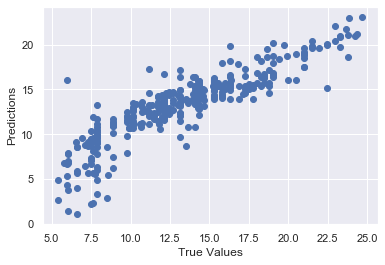

In [96]:
plt.scatter(Y_test, predictions);
plt.xlabel('True Values');
plt.ylabel('Predictions');